# Practical session n°5

Notions:
- Semantic segmentation
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 1 h 30 + 2 h

In P2, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).


## Part I: Semantic Segmentation and Image Denoising with Fully Convolutional Networks

This part aims to familiarize you with Fully Convolutional Networks and  pixel-level predictions.

By definition, a Fully Convolutional Network (FCN) does not contain fully connected layers. As a result, the output retains spatial dimensions. This configuration is useful when the learning target itself is an image. This is the case for tasks such as:
- Semantic segmentation, where each pixel is assigned a semantic class (e.g., ground, sky, clouds, buildings, etc.).
- Pixel-wise regression
- Image denoising
- Super-resolution

The first exercise features an FCN built from a ResNet50 for a simple segmentation task defined from a set of real images segmented by hand.

The second exercise proposes a pixel-wise regression task, completely supervised, defined on a set of dynamically generated synthetic images.

### **Exercise 1: Semantic Segmentation with FCN-ResNet (no training)**

**A.** Presentation of the Dataset

In the following cells, we load the necessary libraries, download the set of segmented images prepared for the [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/segexamples/index.html) challenge, and visualize input-target pairs from the training set:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

In [2]:
# Check GPU availability

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
import os
root = "/content/data"
os.makedirs(root, exist_ok=True)

# Download from BrainChip mirror
!wget http://data.brainchip.com/dataset-mirror/voc/VOCtrainval_06-Nov-2007.tar \
     -O /content/data/VOCtrainval_06-Nov-2007.tar
! tar -xf /content/data/VOCtrainval_06-Nov-2007.tar -C /content/data

--2025-12-05 06:07:24--  http://data.brainchip.com/dataset-mirror/voc/VOCtrainval_06-Nov-2007.tar
Resolving data.brainchip.com (data.brainchip.com)... 146.59.209.152, 2001:41d0:301::31
Connecting to data.brainchip.com (data.brainchip.com)|146.59.209.152|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.brainchip.com/dataset-mirror/voc/VOCtrainval_06-Nov-2007.tar [following]
--2025-12-05 06:07:24--  https://data.brainchip.com/dataset-mirror/voc/VOCtrainval_06-Nov-2007.tar
Connecting to data.brainchip.com (data.brainchip.com)|146.59.209.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘/content/data/VOCtrainval_06-Nov-2007.tar’

/content/data/VOCtr 100%[===================>] 438.72M  79.2MB/s    in 5.3s    

2025-12-05 06:07:30 (83.0 MB/s) - ‘/content/data/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [4]:
# Load the training dataset

input_resize = transforms.Resize((128, 128))
target_resize = transforms.Resize((128, 128))

train_dataset_viz = datasets.VOCSegmentation(
    './data',
    year='2007',
    image_set='train',
    download = False,
    transform=input_resize,
    target_transform=target_resize,
)

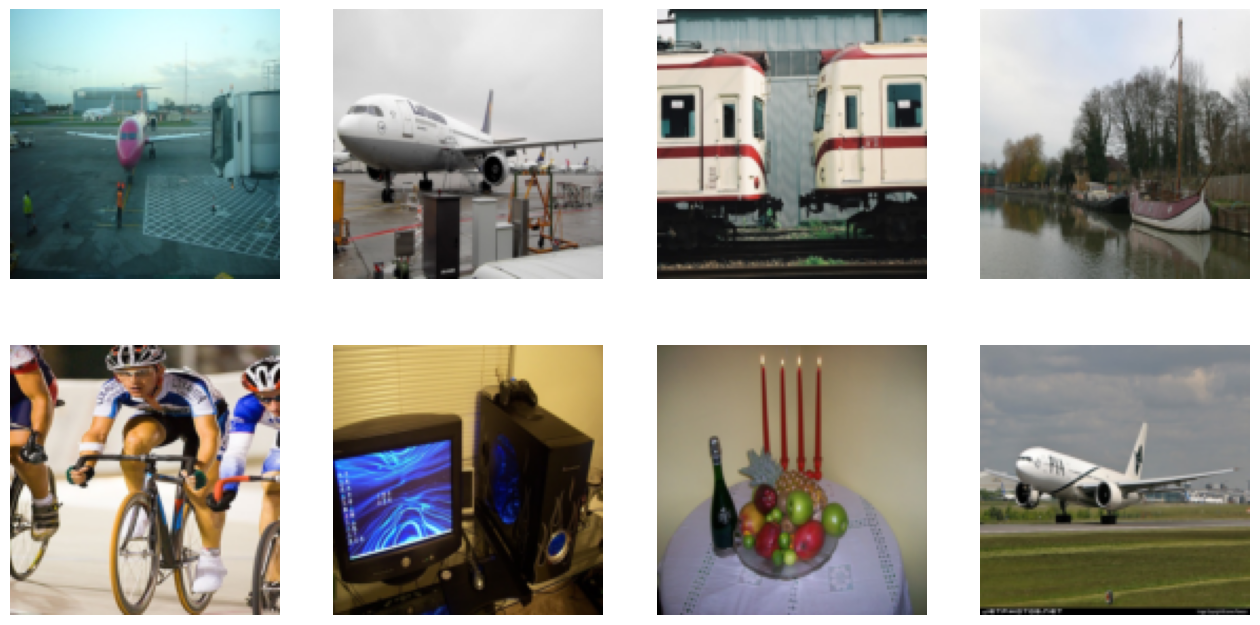

In [5]:
# Viz some images

import math

def plot_images(images, num_per_row=4, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row,figsize=(4*num_per_row,4*num_rows))
    #fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig

# Echantilonnage du dataset de viz:

inputs, ground_truths = list(zip(*[train_dataset_viz[i] for i in range(8)]))

_ = plot_images(inputs)

In [ ]:
# Viz some targets

_ = plot_images(ground_truths)

**Question 1:** How many classes are there?

---


Search the web for the difference between semantic segmentation and instance segmentation. What type of segmentation is this dataset about?

In [ ]:
# num_classes = ...

num_classes = 21



1. **Semantic Segmentation:**
   - **Objective:** Assign a class label to each pixel in an image, indicating the category or type of the object to which it belongs.
   - **Target:** The segmentation masks indicate the class or category of each pixel.


2. **Instance Segmentation:**
   - **Objective:** Identify and outline individual objects in an image.
   - **Target:** The mask contains the same value for each set of pixels associated with the same physical object.



Here, the segmentation task is a semantic segmentation, where each pixel is assigned a class label representing the category of the object to which it belongs. The classes may include categories like ground, sky, clouds, buildings, etc.


**B.** Presentation of an FCN-ResNet

In the next cell, we load an [FCN](https://pytorch.org/vision/stable/models/fcn.html) built from a [ResNet50](https://arxiv.org/pdf/1512.03385.pdf). This model achieved state-of-the-art performance in 2015 according to [paperswithcode](https://web.archive.org/web/20250325222837/https://paperswithcode.com/sota/).

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights_backbone = None)


**Q2:** What is different from a standard ResNet50? Does the FCN provide an output of the same size as the input? Test and explain.

In [ ]:
# sample the dataset, convert to torch.tensor:
batch_size = 4
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize([64,64])
target_resize = transforms.Resize([64,64])

# Transforms used during the training :
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

# Def of the Dataset object :
train_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
inputs, targets  = next(iter(train_loader))


# Test here :
y = fcn(inputs)
print(y.keys())
print(inputs.shape, targets.shape, y['out'].shape)

odict_keys(['out'])
torch.Size([4, 3, 64, 64]) torch.Size([4, 64, 64]) torch.Size([4, 21, 64, 64])


In [ ]:
resnet50 =  torchvision.models.resnet50()
print(resnet50)

In [ ]:
print(fcn)

In [ ]:
# Decomposition:
y = fcn.backbone(inputs)
print(y['out'].shape)

print(fcn.classifier(y['out']).shape)


import inspect

# Assuming `model` is your PyTorch model instance
print(inspect.getsource(fcn.forward))

In summary, compared to a standard ResNet50:
- The final perceptron is replaced by a fully convolutional "head" ([FCNhead](https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/fcn.py)).
- The stride = 2 is replaced by dilation. While a stride = 2 implies a spatial dimension reduction by half, this is not the case with a dilation = 2 / 4 (see this [illustration](https://github.com/vdumoulin/conv_arithmetic)).
- The forward pass involves an interpolation step at the end.

**C. Testing a Pretrained Network**

In this exercise, we simply **test** a model trained on another segmentation dataset. An extension to this exercise provides an opportunity to train the model introduced in exercise sheet #2.

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1')

In [ ]:
batch_size = 16
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize((256,256))
target_resize = transforms.Resize((256,256))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
    ]
)

test_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

In [ ]:
# Creating loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

**Q3:** According to the preceding code lines, which set (validation or test) of PascalVOC2007 are we testing the model on? Why?



We are testing our model on a "validation set". Generally, the test targets of a challenge are not published. For this reason, such a validation set is often used as a test bench, even in the literature. \\
It doesn't mean that there was no validation step during the training of the model. In our specific case, the real validation took place on [COCO](https://cocodataset.org/#stuff-2017), and our test is performed on the PascalVOC validation set.



Now, let's visualize some model outputs on this set:

In [ ]:
# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [ ]:
inputs, targets = next(iter(test_loader))
outputs = fcn(inputs)['out']
outputs = outputs.argmax(1)

outputs = replace_tensor_value_(outputs, 21, 255)
targets = replace_tensor_value_(targets, 21, 255)
targets = targets.squeeze(dim=1)

In [ ]:
plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs.numpy()]
fig = plot_images(pil_outputs)
fig.suptitle("Predictions")

pil_targets = [array1d_to_pil_image(gt) for gt in targets.numpy()]
fig = plot_images(pil_targets)
_ = fig.suptitle("Ground truths")

Now, let's evaluate the model on the entire set.

In [ ]:
# For the test metric
!pip install torchmetrics

In [ ]:
import torchmetrics
IoU = torchmetrics.JaccardIndex(num_classes=21, ignore_index=255,task="multiclass")

Q4: Jaccard Index is used instead of accuracy. How is it defined? What is its other name? What is its advantage?


Jaccard Index, also known as Intersection over Union (IoU), measures the overlap between two sets (predicted and observed), calculated as the ratio of the intersection to the union.

   $$IoU = \frac{\text{Area of Intersection}}{\text{Area of Union}}$$

In a multiclass context, this value is computed for each class and averaged.
Jaccard Index is suitable for imbalanced classes, and insensitive to absolute size because it focuses on relative overlap.


Q5: Modify the following code to obtain an average IoU over the entire set

In [ ]:
fcn = fcn.to(device)
fcn.eval()
nbatch = 0
sum_batch_IoU = 0
for i, (inputs, targets) in enumerate(test_loader):
  targets = targets.squeeze(dim=1)
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = fcn(inputs)['out']

  outputs = outputs.cpu()
  targets = targets.cpu()
  batch_IoU = IoU(outputs, targets)
  nbatch +=1
  sum_batch_IoU += batch_IoU
  print(batch_IoU)

print('mean IoU :', sum_batch_IoU/nbatch)

### **Exercise 2: Perfectly Supervised Denoising**

In a perfectly supervised denoising problem, we have two sets of images $B_{noisy}$ and $B_{clean}$.
Each clean image in $B_{clean}$ corresponds to a noisy version in $B_{noisy}$. \\
In this exercise, we will train an FCN to transform the noisy version into the clean one. To avoid using real data that would take up space on the drive, we work on synthetic images generated on the fly. We are thus in the ideal scenario where the datasets are infinitely large, and overfitting is not a concern.
In this context, data augmentation and validation steps are unnecessary, simplifying the training procedures.
The following cells visualize data from $B_{noisy}$ and their corresponding "clean" counterparts. The function $gen$ (in the module  **utile.py**) samples batches on the fly.

In [ ]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/P4/src/utile.py .
from utile import gen, voir_batch2D

In [ ]:
input, target = gen(6)

# Noisy versions (filled and noisy rectangles)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# Clean versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0, max_scale=1)

The task is to remove the rectangles (filled or not) from the image. It is a well-posed but a priori challenging problem: spatial context is necessary to achieve it. To address this, we will use another popular FCN: a simplified [U-Net](https://arxiv.org/abs/1505.04597) (see utile.py).

In [ ]:
ch_in = 1
ch_out = 1
size = 16

fcn = UNet(ch_in, ch_out, size).to(device)  # 1 input channel, 1 output channel, network size parameter: 16

**Q1:** How many convolution layers does this U-Net contain? How many weights in total when $size = 16$?

In [ ]:
#print(fcn)
i=0
for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      i+=1

print(i)

pconv=0
pconvt=0
pbn=0
ptot=0

for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      for parameter in module.parameters():
        pconv += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.ConvTranspose2d):
      for parameter in module.parameters():
        pconvt += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.BatchNorm2d):
      for parameter in module.parameters():
        pbn += torch.numel(parameter)

print(pconv)  # number of weights in convolution layers
print(pconvt) #  " " in transpose convolution layers
print(pbn)    # number of weights in BatchNorm layers

print(pconv + pconvt + pbn)

**Q2:** For an input image with spatial dimensions $64\times 64$, what is the dimension of the intermediate feature map?

In [ ]:
fcn

The successive convolutions preserve the dimensions (due to "padding" - a layer of zeros on each side). The four successive maxpooling operations reduce the spatial dimensions to $4 \times 4$.

**Q3:** How is the multi-scale processing ensured? What is the purpose of "skip-connections"?

### BEGIN SOLUTION

In the forward function of the network (see utile.py), the feature maps calculated during the compression phase are directly reinjected into the inputs of the final modules, by concatenation. These short-circuits ("skip-connections") allow the mixing of low-level, local information with high-level, more global information. According to sources, these skip-connections improve the resolution of the output image and facilitate the backpropagation of gradients to the early layers of the network.

### END SOLUTION

**Q4:** Define a simple training procedure (no validation) using Mean Square Error (MSE) as the cost function and Adam as the optimization method (learning rate of 0.001). Once the training procedure is ready, associate a GPU with the notebook and ensure that the denoising task is well learned.

In [ ]:
fcn = fcn.to(device)

In [ ]:
def criterion(output, target):
    return torch.mean((output - target)**2)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 40  # brew a tea while waiting
nbatches = 100  # Number of batches per epoch
batchsize = 32  # Batch size

train_losses = []  # List to store training losses

fcn = fcn.to(device)

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        inputs, targets = gen(batchsize)
        ### BEGIN SOLUTION
        # Move data to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = fcn(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        epoch_losses.append(loss.detach().cpu().item())  # Append the loss
        ### END SOLUTION
    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

In [ ]:
plt.plot(train_losses)

In [ ]:
#visualization:

fcn.eval()

target = make_batch(6, rec=0., noisy_rec=0., disc=0.002).to(device)
noise = make_batch(6, rec=0.0003, noisy_rec=0.0003, disc=0.).to(device)
input = target + noise

# output =

### BEGIN SOLUTION
output = fcn(input)

fig = plt.figure(0, figsize=(36, 6))  # first row: inputs
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  # second row: ground truth
voir_batch2D(target.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  # last row: outputs
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)
### END SOLUTION